In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import inspect

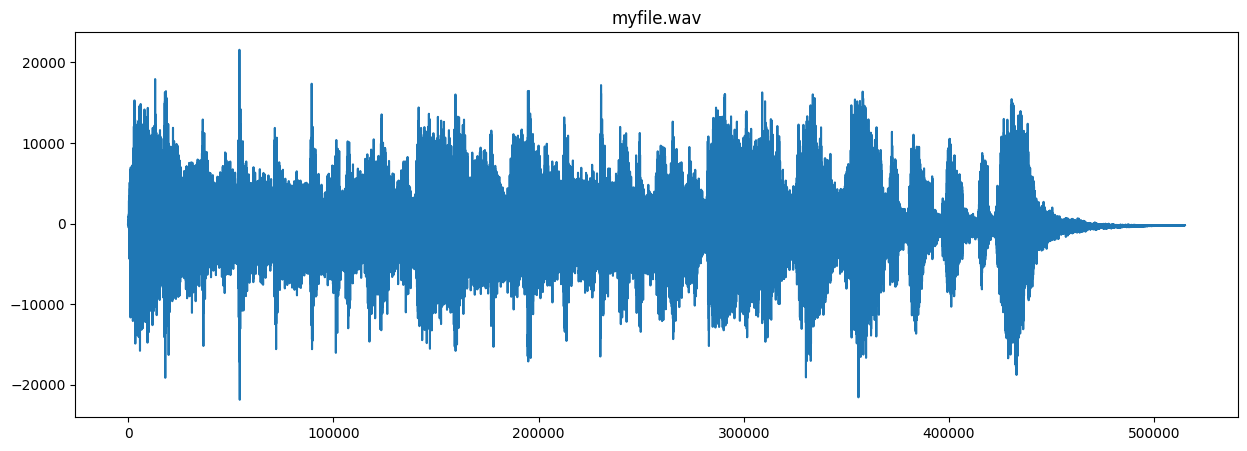

In [4]:
fs, wavin = wavfile.read('./scripts and data/myfile.wav')

plt.figure(figsize=(15, 5))

plt.plot(wavin)
plt.title('myfile.wav')
plt.show()

## 3.1 Subband filtering

Text(0.5, 1.0, 'h(n)')

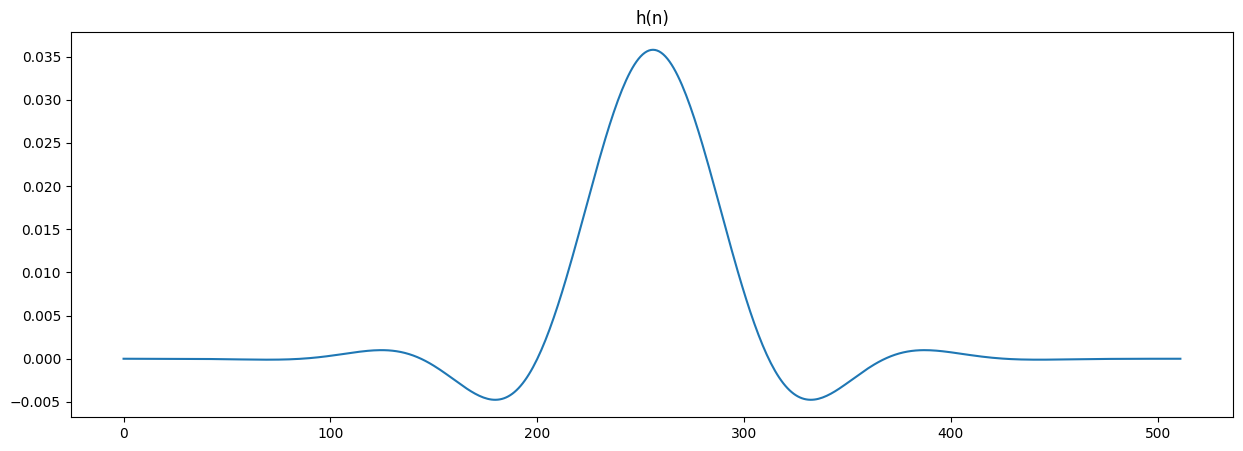

In [5]:

h = np.load('./scripts and data/h.npy', allow_pickle=True).tolist()['h'].reshape(-1)
plt.figure(figsize=(15, 5))
plt.plot(h)
plt.title('h(n)')

In [6]:
M = 32 # of subbands
L = 512 # length of filters
N = 36 # samples for each filter

def make_mp3_analysisfb(h: np.ndarray, M: int) -> np.ndarray:
    H = np.zeros([len(h), M], dtype=np.float32)
    for i in range(1, M + 1):
        n = np.arange(h.shape[0], dtype=np.int64)
        freq_i = (2 * i - 1) * np.pi / (2.0 * M)
        phas_i = -(2 * i - 1) * np.pi / 4.0
        tmp = np.cos(freq_i * n + phas_i)
        x = np.multiply(h, tmp)
        H[:, i - 1] = x
    return H

def make_mp3_synthesisfb(h: np.ndarray, M: int) -> np.ndarray:
	H = make_mp3_analysisfb(h, M)
	L = len(h)
	G = np.flip(H, axis=0)
	return G

H = make_mp3_analysisfb(h, M)
G = make_mp3_synthesisfb(h, M)

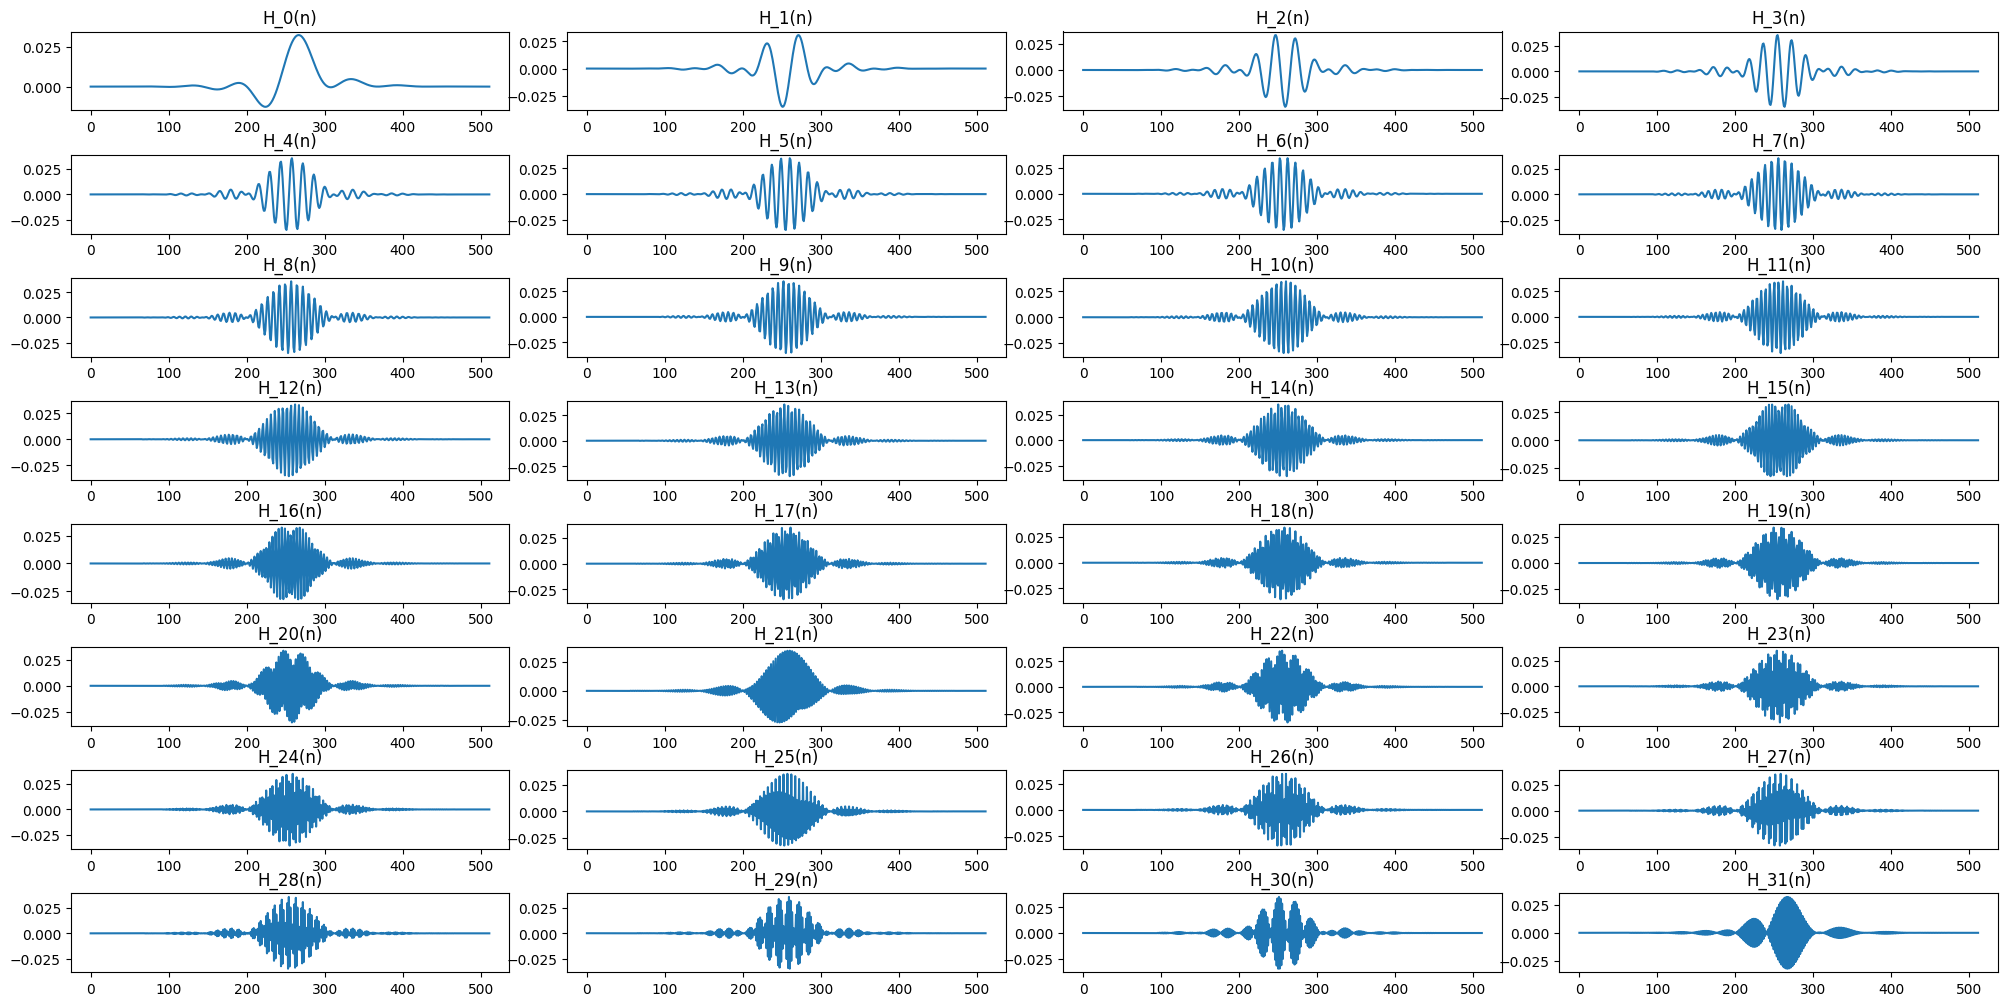

In [7]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 10))
fig.tight_layout()

for i in range(M):
    plt.subplot(8, 4, i + 1)
    plt.plot(H[:, i])
    plt.title(f'H_{i}(n)')

plt.show()

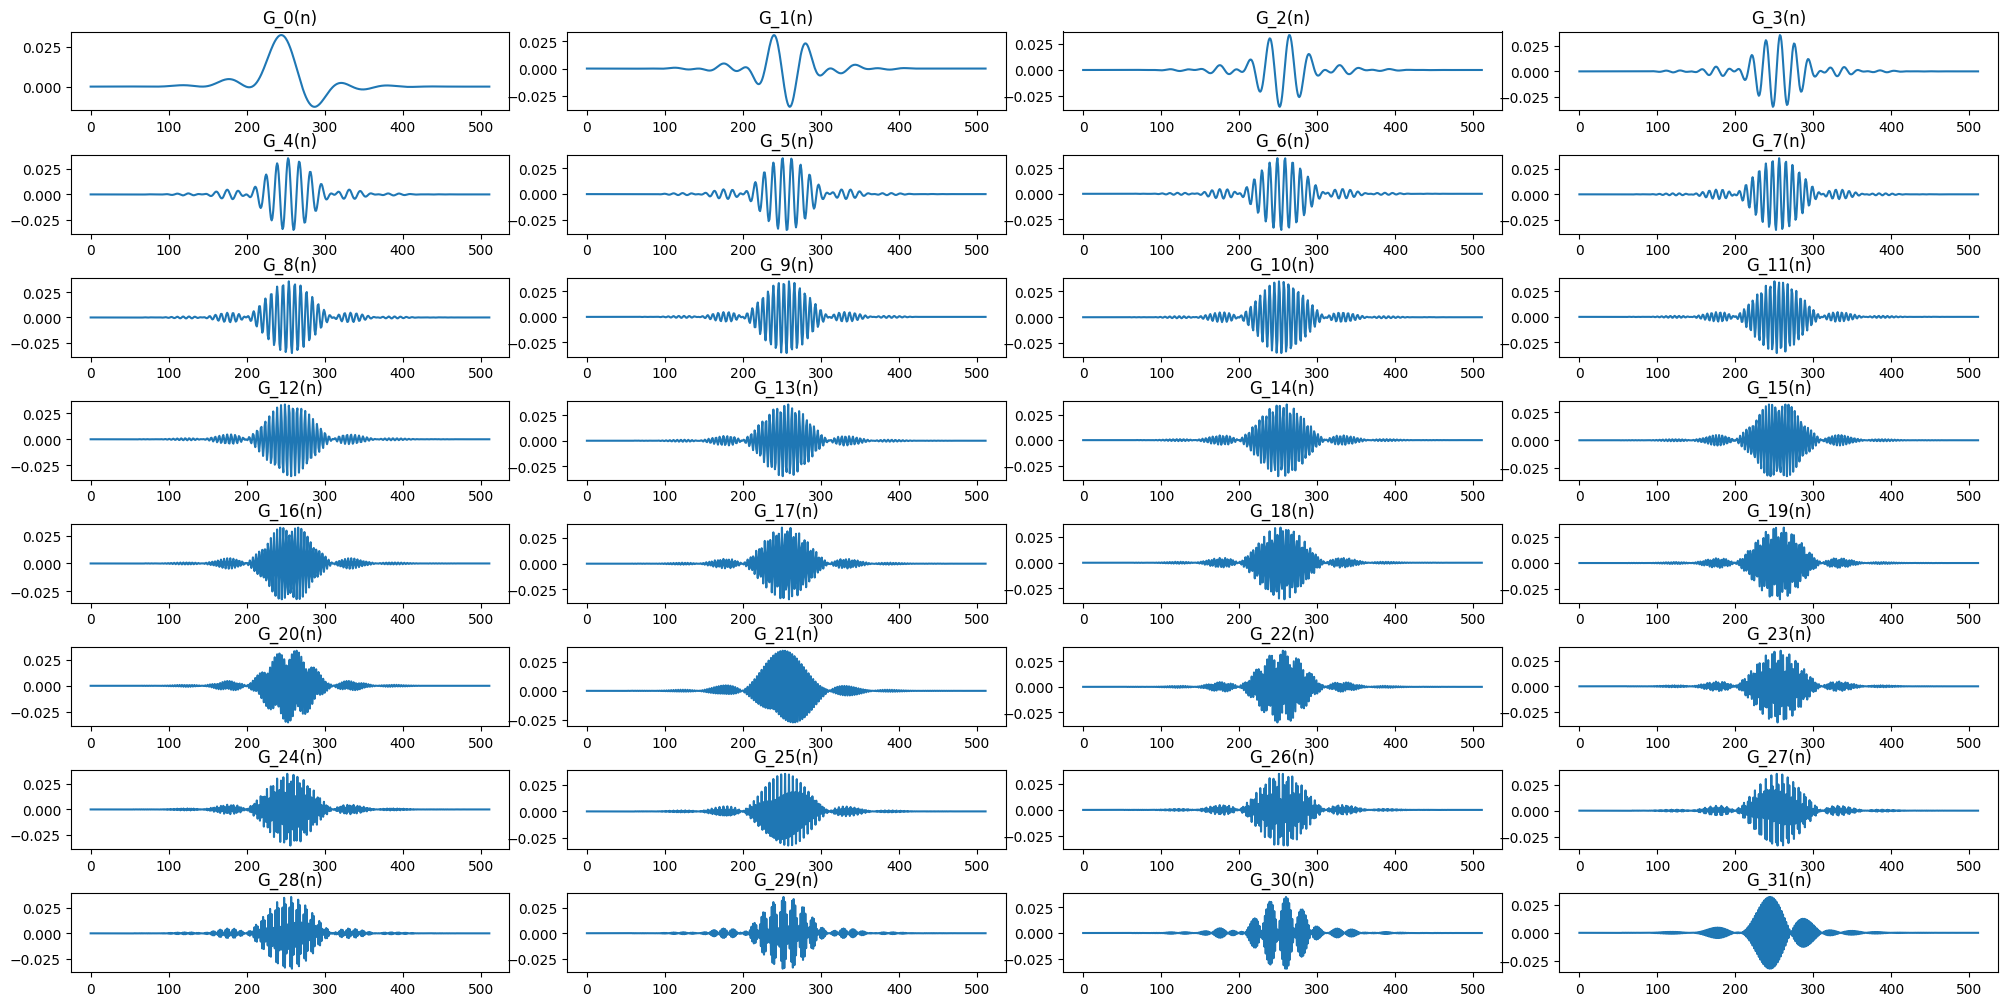

In [8]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 10))
fig.tight_layout()

for i in range(M):
    plt.subplot(8, 4, i + 1)
    plt.plot(G[:, i])
    plt.title(f'G_{i}(n)')

plt.show()

In [7]:
def frame_sub_analysis(xbuff: np.ndarray, H: np.ndarray, q: int) -> np.ndarray:
	"""
	"""
	L, M = H.shape
	ind = np.zeros([q, L])
	ind[0, :] = np.arange(L)

	for i in range(1, q):
		ind[i, :] += ind[i - 1, :] + M
	ind = ind.astype(np.int64)
	X = xbuff[ind]
	Y = np.einsum('ik,kj->ij', X, H)
	return Y


def frame_sub_synthesis(ybuff: np.ndarray, G: np.ndarray) -> np.ndarray:
	"""
	"""
	L, M = G.shape
	N = int(np.ceil(L / M))

	Gr = G.reshape(M, M * N, order='F').copy()
	Z = np.zeros([1152])
	for n in range(ybuff.shape[0] - N):
		tmp = ybuff[n:n + N, :].T.flatten()
		yr = np.expand_dims(tmp, axis=-1)
		z = np.dot(Gr, yr)
		Z[n * M:(n + 1) * M] = M * np.flip(z[:, 0])
	return Z.T.flatten()

def idonothing(Yc: np.ndarray) -> np.ndarray:
	return Yc

def donothing(Yc: np.ndarray) -> np.ndarray:
	return Yc

In [204]:
def coder0(wavin, h, M, N):

    Ytot = np.empty(shape=(0, M))

    xbuffer_size = int((N - 1) * M + L)
    frame_size = M * N

    frames = np.split(ary=wavin,
                      indices_or_sections=int(len(wavin) / frame_size),
                      axis=0)

    for (i, frame) in enumerate(frames):
        if i == len(frames) - 1:
            xbuffer = np.r_[frame, np.zeros(xbuffer_size - frame_size)]
        else:
            xbuffer = np.r_[frame, frames[i + 1][:xbuffer_size - frame_size]]

        Y = frame_sub_analysis(xbuffer, H, N)
        Yc = donothing(Y)
        Ytot = np.r_[Ytot, Yc]

    return Ytot

def decoder0(Ytot, h, M, N):
    ybuffer_size = int(((N - 1) + L / M))

    frames = np.split(ary=Ytot,
                      indices_or_sections=int(len(Ytot) / N),
                      axis=0)

    for (i, frame) in enumerate(frames):

        Yh = idonothing(frame)

        if i == len(frames) - 1:
            ybuffer = np.r_[frame, np.zeros((ybuffer_size - len(frame), M))]
        else:
            ybuffer = np.r_[frame, frames[i+1][:ybuffer_size - len(frame), :]]

        if i == 0:
            xhat = frame_sub_synthesis(ybuffer, G)
        else:
            xhat = np.r_[xhat, frame_sub_synthesis(ybuffer, G)]

    return xhat

In [205]:
Ytot = coder0(wavin, H, M, N)
xhat = decoder0(Ytot, H, M, N)

In [206]:
Ytot.shape, xhat.shape

((16092, 32), (514944,))